In [1]:
from os import listdir
from os.path import isfile, join
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.utils import AnalysisException
from pyspark.sql.functions import sum as spark_sum, col, collect_list

# conf = (SparkConf()
#     .set("spark.driver.maxResultSize", "10g") \
#     .set("spark.driver.memory", "20g"))
# sc = SparkContext(conf=conf)
# sqlContext = SQLContext(sc)

spark = SparkSession.builder \
    .appName("QueryScript") \
    .config("spark.driver.maxResultSize", "10g") \
    .config("spark.driver.memory", "20g") \
    .getOrCreate()

def query_table(file_name):
    try:
        df = spark.read.parquet(file_name)
        df.createOrReplaceTempView("test_df")
        result = spark.sql("""
            SELECT s, t, c_list, size(c_list) as num_pages,
                aggregate(c_list, 0, (x, y) -> x + y) as details_sum
            FROM test_df ORDER BY details_sum DESC
        """)
        return result
    except AnalysisException as e:
        # Catch and ignore errors
        print(f"Error processing {file_name}: {e}")
        return None
    
# query_table("spark-warehouse/output_table_2199").show(10)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/05 09:14:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
import pandas as pd
from os import listdir
from os.path import join
from pyspark.sql import SparkSession
from tqdm import tqdm 
from pyspark.sql.functions import sum as spark_sum, collect_list, col
import os

def query_all_tables(directory):
    files = [f for f in listdir(directory)]
    
    all_results = []
    spark = SparkSession.builder.appName("Example").getOrCreate()
    for file_name in tqdm(files):
        result_df = query_table(join(directory, file_name))
        if result_df:
            # Convert each PySpark DataFrame to Pandas DataFrame
            pandas_df = result_df.toPandas()
            all_results.append(pandas_df)

    print(len(all_results))

    # Concatenate all Pandas DataFrames
    grouped_df = pd.concat(all_results) if all_results else None
    
    # Group by s and t using Pandas operations
    grouped_df = grouped_df.groupby(["s", "t"]).agg(
        {"num_pages": "sum", "details_sum": "sum", "c_list": lambda x: x.tolist()}
    ).reset_index()
    grouped_df["ratio"] = grouped_df["details_sum"] / grouped_df["num_pages"]
    
    spark.stop()  # Stop the SparkSession to release resources
    return grouped_df

if os.path.exists("link_dists.pkl"):
    print("Loading from pickle")
    df_link_dists_full = pd.read_pickle("link_dists.pkl")
else:
    print("Querying all tables")
    df_link_dists_full = query_all_tables("spark-warehouse/")
    print("Saving df_link_dists to link_dists.pkl")
    df_link_dists_full.to_pickle("link_dists.pkl")
    # get size of df_link_dists
    print(df_link_dists_full.shape)
    # size in GB
    print(df_link_dists_full.memory_usage(deep=True).sum() / (1024 ** 3))

Loading from pickle


In [ ]:
known_podcasts = [
    'player.fm/series/',
    'podbean.com',
    'libsyn.com',
    # 'buzzsprout.com',
    # 'last.fm',
    # 'lastfm.com',
    # 'podcastaddict.com',
    # 'podcasts.apple.com',
    # 'spotify.com/show/',
]

def is_podcast(url):
    return any(provider in url for provider in known_podcasts)

df_link_dists = df_link_dists_full[df_link_dists_full['s'].apply(is_podcast)]

def reverse_url(url):
    components = url.split('.')
    reversed_url = '.'.join(components[::-1])
    return reversed_url

df_link_dists['t'] = df_link_dists['t'].apply(reverse_url)
df_link_dists.head(10)

,s,t,num_pages,details_sum,c_list,ratio
836953,http://aboveandbeyond.podbean.com/2012/10/24/a...,com.cloudflare.cdnjs,1,1,[[1]],1.0
836954,http://aboveandbeyond.podbean.com/2012/10/24/a...,com.googleapis.fonts,1,1,[[1]],1.0
836955,http://aboveandbeyond.podbean.com/2012/10/24/a...,com.gstatic.fonts,1,1,[[1]],1.0
836956,http://aboveandbeyond.podbean.com/2012/10/24/a...,net.cloudfront.d8g345wuhgd7e,1,2,[[2]],2.0
1278120,http://aduecker.podbean.com/2010/11/14/rv-adve...,com.cloudflare.cdnjs,1,1,[[1]],1.0
1278121,http://aduecker.podbean.com/2010/11/14/rv-adve...,com.googleapis.fonts,1,1,[[1]],1.0
1278122,http://aduecker.podbean.com/2010/11/14/rv-adve...,com.gstatic.fonts,1,1,[[1]],1.0
1278123,http://aduecker.podbean.com/2010/11/14/rv-adve...,net.cloudfront.d8g345wuhgd7e,1,2,[[2]],2.0
1278124,http://aduecker.podbean.com/2010/11/15/the-mis...,com.cloudflare.cdnjs,1,1,[[1]],1.0
1278125,http://aduecker.podbean.com/2010/11/15/the-mis...,com.googleapis.fonts,1,1,[[1]],1.0


In [ ]:
import pandas as pd
import numpy as np
# add parent to sys.path
import sys
sys.path.append('../cc-pyspark')
from wat_extract_links import ExtractLinksJob

def is_substring(row, col_a, col_b):
    return row[col_a] not in row[col_b]

df_link_dists['s_d'] = df_link_dists['s'].apply(ExtractLinksJob.get_surt_host)
df_link_dists['s_d'] = df_link_dists['s_d'].apply(reverse_url)

# labels = pd.read_csv('../data/attributes.csv')[['url','label']]
labels = pd.read_csv('data/news_ratings_11k.csv')[['domain', 'pc1']]
labels.columns = ['url','label']
df_link_dists_labelled = df_link_dists.merge(right=labels, left_on='t', right_on='url', how='inner')
df_link_dists_labelled = df_link_dists_labelled[~df_link_dists_labelled.apply(lambda row: row['t'] in row['s'], axis=1)]
df_link_dists_labelled = df_link_dists_labelled[~df_link_dists_labelled.apply(lambda row: row['s'] in row['t'], axis=1)]
# rename c_list to link_dist
df_link_dists_labelled.rename(columns={'c_list': 'link_dist'}, inplace=True)
df_link_dists_labelled['link_dist'] = df_link_dists_labelled['link_dist'].apply(np.concatenate)
df_link_dists_labelled.describe()

/tmp/ipykernel_3447463/671365887.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_link_dists['s_d'] = df_link_dists['s'].apply(ExtractLinksJob.get_surt_host)
/tmp/ipykernel_3447463/671365887.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_link_dists['s_d'] = df_link_dists['s_d'].apply(reverse_url)


,num_pages,details_sum,ratio,label
count,63698.000000,63698.000000,63698.000000,63698.000000
mean,1.056470,2.214952,2.098109,0.788281
std,0.489427,4.844212,4.725985,0.099363
min,1.000000,1.000000,1.000000,0.000000
25%,1.000000,2.000000,2.000000,0.808778
50%,1.000000,2.000000,2.000000,0.808778
75%,1.000000,2.000000,2.000000,0.808778
max,22.000000,568.000000,568.000000,1.000000


## TODO: Multiplicity

In [45]:
from scipy.stats import skew
import seaborn as sns
import math

def aggregate_link_dist(link_dist_list):
    result_list = []
    for sublist in link_dist_list:
        result_list.extend(sublist)
    return [result_list]

def link_dist_metrics(df):
    df['mean'] = df['link_dist'].apply(np.mean)
    df['skew'] = df['link_dist'].apply(skew)
    df['variance'] = df['link_dist'].apply(np.var)
    df['stddev'] = df['variance'].apply(math.sqrt)
    df['links_per_page'] = df['total_details_sum'] / df['total_num_pages']
    return df

# Define aggregation functions for each column
page_aggregation_dict = {
    'link_dist': aggregate_link_dist,
    'total_details_sum': 'sum',
    'total_num_pages': 'sum',
    'label': 'mean',
}
# rename details_sum to total_details_sum and num_pages to total_num_pages
df_link_dists_page_aggregated = df_link_dists_labelled.rename(columns={'details_sum': 'total_details_sum', 'num_pages': 'total_num_pages'})
df_link_dists_page_aggregated = df_link_dists_page_aggregated.groupby(['s']).agg(page_aggregation_dict).reset_index()
df_link_dists_page_aggregated = link_dist_metrics(df_link_dists_page_aggregated)
df_link_dists_page_aggregated[df_link_dists_page_aggregated['stddev']>10].head(10)

,s,link_dist,total_details_sum,total_num_pages,label,mean,skew,variance,stddev,links_per_page
33902,https://feed.podbean.com/ChatShtGetFit/feed.xml,"[[2, 2, 2, 2, 10, 26, 22, 2, 14, 4, 78, 2, 2, ...",611,33,0.750860,18.515152,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2736.977043,52.316126,18.515152
33936,https://feed.podbean.com/activemotif/feed.xml,"[[30, 4, 1]]",35,3,0.912901,11.666667,"[nan, nan, nan]",169.555556,13.021350,11.666667
33962,https://feed.podbean.com/banklessafrica/feed.xml,"[[2, 2, 4, 2, 2, 10, 46, 2, 2, 4, 4, 2, 2, 2, ...",102,15,0.771395,6.800000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",124.160000,11.142711,6.800000
33966,https://feed.podbean.com/bfgamers/feed.xml,"[[90, 120]]",210,2,0.161394,105.000000,"[nan, nan]",225.000000,15.000000,105.000000
33974,https://feed.podbean.com/bobdailey/feed.xml,"[[58, 2, 8, 2, 18, 4]]",92,6,0.771325,15.333333,"[nan, nan, nan, nan, nan, nan]",394.222222,19.855030,15.333333
34039,https://feed.podbean.com/droppingloads/feed.xml,"[[4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 6, 2, 4, 28...",754,93,0.711676,8.107527,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",893.106718,29.884891,8.107527
34080,https://feed.podbean.com/geekshowpodcast/feed.xml,"[[2, 94, 2, 2, 2, 2, 2, 2, 2, 144, 4, 14, 2, 1...",442,28,0.783247,15.785714,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1098.954082,33.150476,15.785714
34224,https://feed.podbean.com/newmexiconewspodcast/...,"[[2, 178, 2, 2]]",184,4,0.785435,46.000000,"[nan, nan, nan, nan]",5808.000000,76.210236,46.000000
34304,https://feed.podbean.com/shemanefitness/feed.xml,"[[4, 4, 2, 153, 2, 2, 4, 2, 108, 2]]",283,10,0.365624,28.300000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",2713.210000,52.088482,28.300000
34368,https://feed.podbean.com/themelkshow/feed.xml,"[[122, 122, 122, 2, 128, 2, 122]]",620,7,0.329591,88.571429,"[nan, nan, nan, nan, nan, nan, nan]",3001.959184,54.790138,88.571429


/tmp/ipykernel_3447463/3333937620.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'page_links_skew': skew(page_link_dist),
/tmp/ipykernel_3447463/3333937620.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cc_backlink_ratings = df_cc_domain_dists.groupby('s_d').apply(weighted_average).reset_index()


,s_d,weighted_average,sum_len_link_dist,sum_link_dist,page_links_skew,page_links_mean,page_links_var
17,accordingtoandrew.podbean.com,0.875986,1.0,1.0,NaN,1.0,0.00
21,activistmmt.libsyn.com,0.653897,4.0,4.0,NaN,4.0,0.00
23,acupodcast.podbean.com,0.713955,4.0,10.0,1.154701,2.5,6.75
25,adapt2030.libsyn.com,0.877262,4.0,6.0,0.000000,3.0,4.00
30,advancedtvherstory.libsyn.com,0.616139,2.0,3.0,NaN,3.0,0.00
...,...,...,...,...,...,...,...
1025,uotuw.podbean.com,0.875986,1.0,1.0,NaN,1.0,0.00
1035,voiceofreasonradio.podbean.com,0.622952,2.0,2.0,NaN,1.0,0.00
1047,wayofthetruthwarrior.podbean.com,0.837494,1.0,1.0,NaN,1.0,0.00
1064,wholeandredeemed.podbean.com,0.832186,1.0,3.0,NaN,3.0,0.00


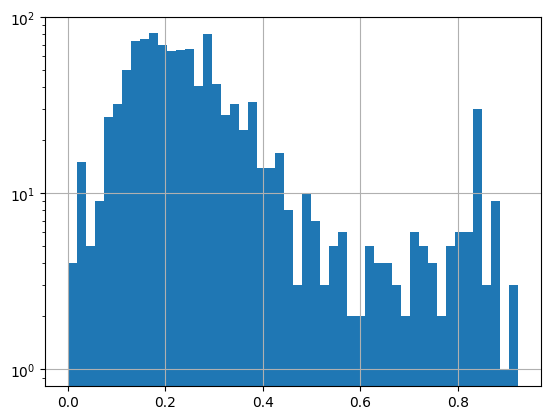

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def weighted_average(group):
    total_weighted_sum = 0
    total_weight = 0
    total_len_link_dist = 0
    total_sum_link_dist = 0
    page_link_dist = []
    
    for index, row in group.iterrows():
        # row['link_dist'] = np.concatenate(row['link_dist'])
        num_links = sum(row['link_dist'])
        total_weighted_sum += num_links * (1-row['label']) # label - mean instead of 1 - label
        total_weight += num_links
        total_len_link_dist += len(row['link_dist'])
        total_sum_link_dist += num_links
        page_link_dist.append(num_links)

    if total_weight == 0:
        return pd.Series({'weighted_average': 0, 'sum_len_link_dist': 0, 'sum_link_dist': 0, 'page_links_skew':0, 'page_links_mean':0, 'page_links_var':0})
    
    return pd.Series({'weighted_average': total_weighted_sum / total_weight,
                      'sum_len_link_dist': total_len_link_dist,
                      'sum_link_dist': total_sum_link_dist,
                      'page_links_skew': skew(page_link_dist), 
                      'page_links_mean': np.mean(page_link_dist), 
                      'page_links_var': np.var(page_link_dist)})

df_cc_domain_dists = df_link_dists_labelled.rename(columns={'num_pages': 'total_num_pages', 'details_sum': 'total_details_sum'})
df_cc_domain_dists = df_cc_domain_dists.groupby(['s_d', 't']).agg(page_aggregation_dict).reset_index()
df_cc_domain_dists['link_dist'] = df_cc_domain_dists['link_dist'].apply(np.concatenate)
df_cc_domain_dists.head(10)
df_cc_backlink_ratings = df_cc_domain_dists.groupby('s_d').apply(weighted_average).reset_index()
df_cc_backlink_ratings['weighted_average'].hist(bins=50)
plt.yscale('log')
df_cc_backlink_ratings[df_cc_backlink_ratings['weighted_average']>0.6]

<Axes: >

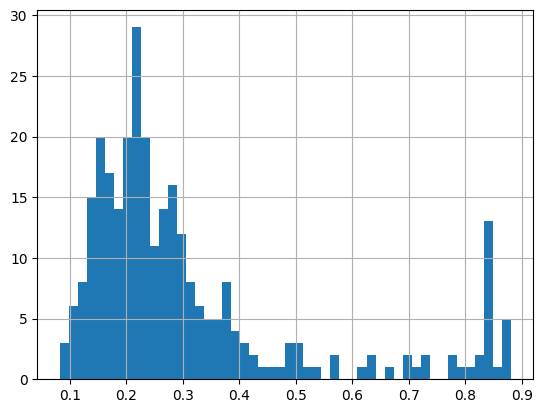

In [ ]:
df_cc_backlink_ratings[(df_cc_backlink_ratings['sum_link_dist']<50)&(df_cc_backlink_ratings['sum_link_dist']>5)]['weighted_average'].hist(bins=50)

In [73]:
# sort by weighted_average is ascending order
df_cc_backlink_ratings_thresholded = df_cc_backlink_ratings[(df_cc_backlink_ratings['sum_link_dist']>5)]
df_cc_backlink_ratings_thresholded.sort_values(by='weighted_average', ascending=False, inplace=True)
podbean_sample = df_cc_backlink_ratings_thresholded[['s_d', 'weighted_average', 'sum_link_dist']]
podbean_sample.rename(columns={'s_d': 'podcast_domain', 'weighted_average': 'outlink_unreliability_score', 'sum_link_dist': 'total_outlinks'}, inplace=True)
podbean_sample

/tmp/ipykernel_3447463/3748668070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_backlink_ratings_thresholded.sort_values(by='weighted_average', ascending=False, inplace=True)
/tmp/ipykernel_3447463/3748668070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  podbean_sample.rename(columns={'s_d': 'podcast_domain', 'weighted_average': 'outlink_unreliability_score', 'sum_link_dist': 'total_outlinks'}, inplace=True)


,podcast_domain,outlink_unreliability_score,total_outlinks
270,eliamano.podbean.com,0.880751,6.0
25,adapt2030.libsyn.com,0.877262,6.0
986,topofthedudechain.podbean.com,0.875986,20.0
494,learnpolish.podbean.com,0.875986,37.0
714,realitycheckwithwill.podbean.com,0.870985,11.0
...,...,...,...
575,moneysavage.podbean.com,0.099763,42.0
797,spacetweeps.podbean.com,0.096223,63.0
315,foreignaffairsmagazine.podbean.com,0.094507,19.0
1059,whatscotuswroteus.podbean.com,0.089944,22.0


In [65]:
df_cc_backlink_ratings[df_cc_backlink_ratings['s_d'].str.contains('libsyn.com')]

,s_d,weighted_average,sum_len_link_dist,sum_link_dist,page_links_skew,page_links_mean,page_links_var
25,adapt2030.libsyn.com,0.877262,4.0,6.0,0.000000,3.000000,4.000000
21,activistmmt.libsyn.com,0.653897,4.0,4.0,NaN,4.000000,0.000000
30,advancedtvherstory.libsyn.com,0.616139,2.0,3.0,NaN,3.000000,0.000000
0,10blocks.libsyn.com,0.401742,22.0,28.0,0.567317,9.333333,59.555556
7,90210blaze.libsyn.com,0.389180,3.0,3.0,NaN,1.000000,0.000000
15,accessibilityminute.libsyn.com,0.385017,8.0,8.0,NaN,8.000000,0.000000
22,actout.libsyn.com,0.373554,4.0,7.0,1.154701,1.750000,1.687500
42,ahealthycuriosity.libsyn.com,0.341741,12.0,12.0,0.649519,2.000000,1.333333
5,42ndstitch.libsyn.com,0.326497,2.0,2.0,NaN,2.000000,0.000000
507,libsyn.com,0.242840,151.0,158.0,4.949737,2.633333,21.565556
